Kalyakin Timofey

# Download required libruaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import trackpy as tp
import porespy as ps
import pyvista as pv


from skimage.filters import difference_of_gaussians
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from skimage.segmentation import random_walker

In [2]:
def plot(image: np.ndarray, title=None):
    """
    Display an image without axes 
    
    Parameters:
    image (numpy.ndarray): Input image
    """

    plt.figure(dpi=300, figsize=(2,3))
    if title:
        plt.title(title)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.show() 

# Make 3D model

In [3]:

def crop_center_array(image, crop_size):
    # cropp function
    if image is None:
        raise ValueError("Ошибка при загрузке изображения. Проверьте путь к файлу.")
        
    height, width = image.shape[:2]
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    return image[top:top + crop_size[1], left:left + crop_size[0]]


def make_3d_model(data_folder):
    # function downloads all pics in grayscale (8-bit), cropp them by center 650 to 650
    # and makes 3d model
    # 3d model  is numpy array
    files_names_list = np.sort(os.listdir(data_folder))
    images_array = []

    for file_name in files_names_list:
        img_path = os.path.join(data_folder, file_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Ошибка загрузки изображения: {img_path}")
            continue 

        cropped_image = crop_center_array(image, crop_size=(650, 650))
        images_array.append(cropped_image)

    model_3d = np.stack(images_array)
    return model_3d

In [ ]:
data_folder = 'Data/Slices'
model_3d = make_3d_model(data_folder)

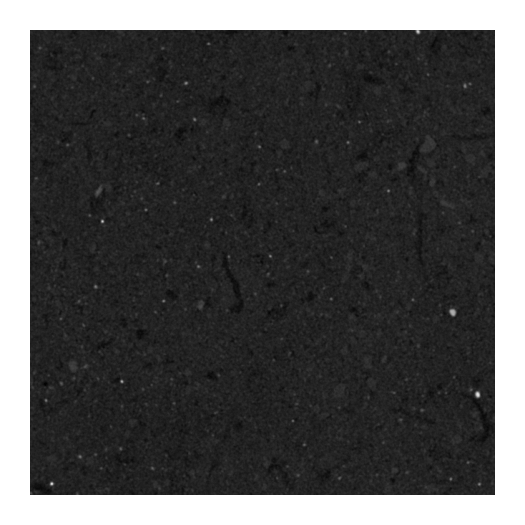

In [5]:
plot(model_3d[100,:,:])

# Model processing 

In [6]:
def profiles_mean_gray_intensity(image, axis='x'):
    """
    Building a profile of the average gray value along the specified axis for 2D or 3D images.

    Parameters:
    image (numpy.ndarray): An image in the form of a 2D or 3D array.
    axis (str): 'x', 'y' or 'z' for three-dimensional images.
    """
    dimensions = image.ndim

    if dimensions == 2:
        if axis == 'x':  
            middle_index = image.shape[0] // 2 
            profile = image[middle_index, :] 
        elif axis == 'y':  
            middle_index = image.shape[1] // 2  
            profile = image[:, middle_index] 
        else:
            raise ValueError("Для 2D изображений допустимы только оси 'x' или 'y'")
            
    elif dimensions == 3:
        if axis == 'x':
            middle_index = image.shape[1] // 2  
            profile = image[:, :, middle_index]  
        elif axis == 'y':
            middle_index = image.shape[2] // 2  
            profile = image[:, middle_index, :]  
        elif axis == 'z':
            middle_index_x = image.shape[1] // 2  
            middle_index_y = image.shape[2] // 2  
            profile = image[:, middle_index_x, middle_index_y]
        else:
            raise ValueError("Для 3D изображений допустимы только оси 'x', 'y' или 'z'")
        
        
        if axis in ['x', 'y']:
            profile = np.mean(profile, axis=0)

    else:
        raise ValueError("Функция поддерживает только 2D и 3D изображения")

    X = np.array(range(len(profile))).reshape(-1, 1)  
    y = profile
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    plt.figure(figsize=(10, 4))
    plt.plot(X, y, linestyle='-', color='gray', label='Intensity Profile')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Polynomial Approximation')
    plt.xlabel(f'{axis} position')
    plt.ylabel('Mean intensity')
    plt.legend()
    plt.grid()
    plt.show()


Lets look on initial data intensity profile

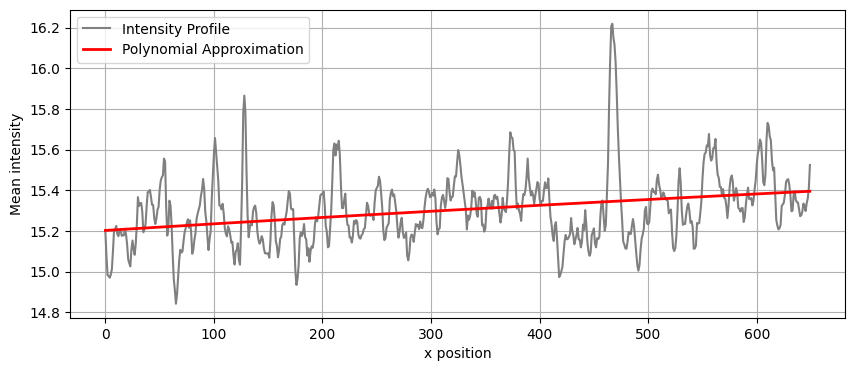

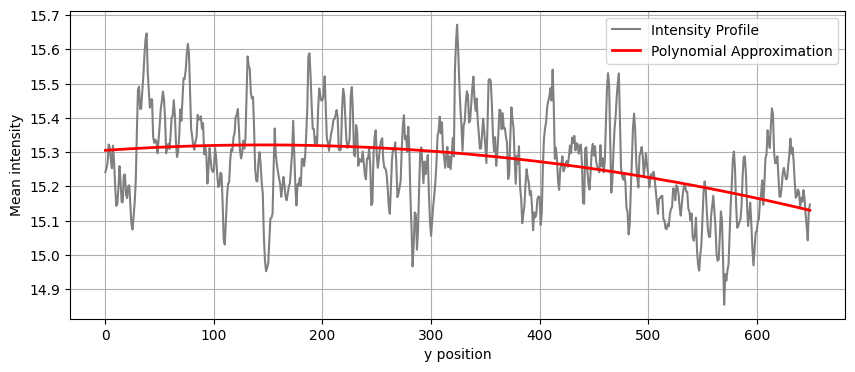

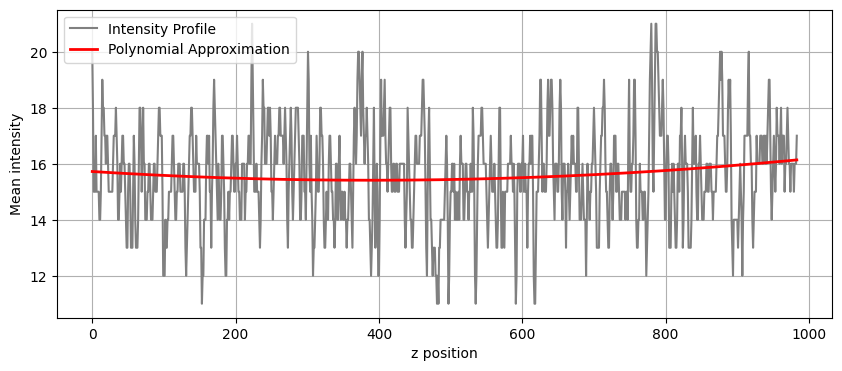

In [7]:
profiles_mean_gray_intensity(model_3d, axis='x')
profiles_mean_gray_intensity(model_3d, axis='y')
profiles_mean_gray_intensity(model_3d, axis='z')

In [8]:
# в это функции по сути надо указать весь набор обработок, которые хотим применить
def process_3d_model(model_3d):
    """
    Обработка 3D модели:
    - Эквализация гистограммы
    - Фильтрация (bandpass или difference of gaussians)
    - Гауссово размытие (блюринг)

    Параметры:
    model_3d (numpy.ndarray): 3D модель для обработки

    Возвращает:
    numpy.ndarray: Обработанная 3D модель
    """
    processed_model = np.zeros_like(model_3d)  # Массив для хранения результата

    for i in range(model_3d.shape[0]):
        
        
        equalized_slice = cv2.equalizeHist(model_3d[i, :, :])

        filtered_slice = difference_of_gaussians(equalized_slice, 1, 12)

        normalized_slice = cv2.normalize(filtered_slice, None, 0, 255, cv2.NORM_MINMAX)
        bit_slice = np.uint8(normalized_slice)

        x = cv2.equalizeHist(bit_slice)

        blurred_slice = cv2.GaussianBlur(x, (5, 5), 0)

        processed_model[i] = blurred_slice

        if i == 600:
            plot(equalized_slice)
            plot(bit_slice)
            plot(blurred_slice)

    return np.stack(processed_model)

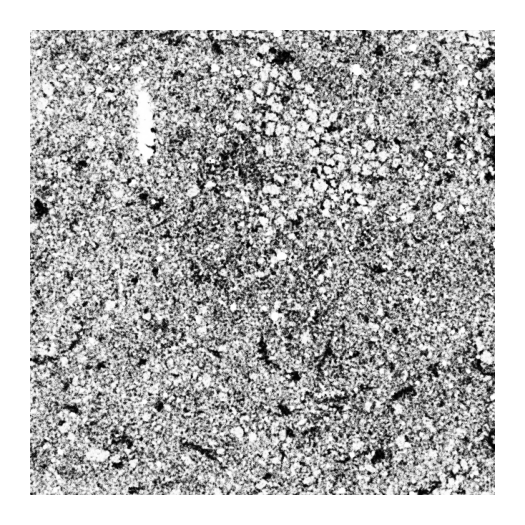

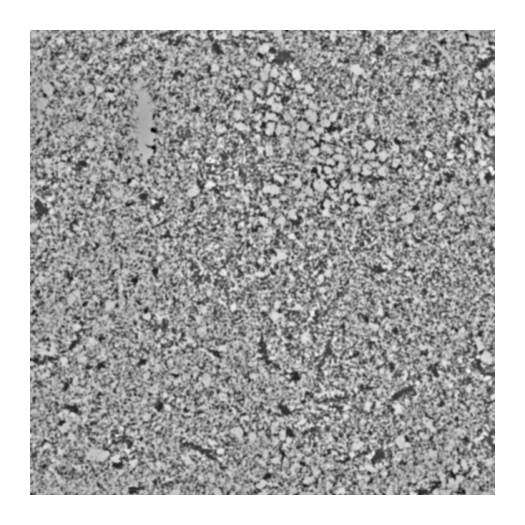

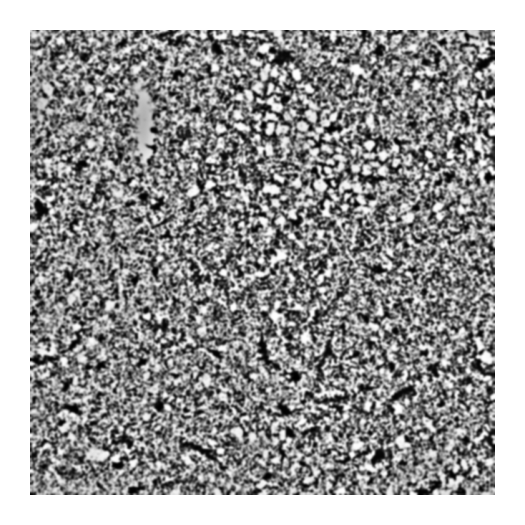

In [9]:
processed_model_3d = process_3d_model(model_3d)

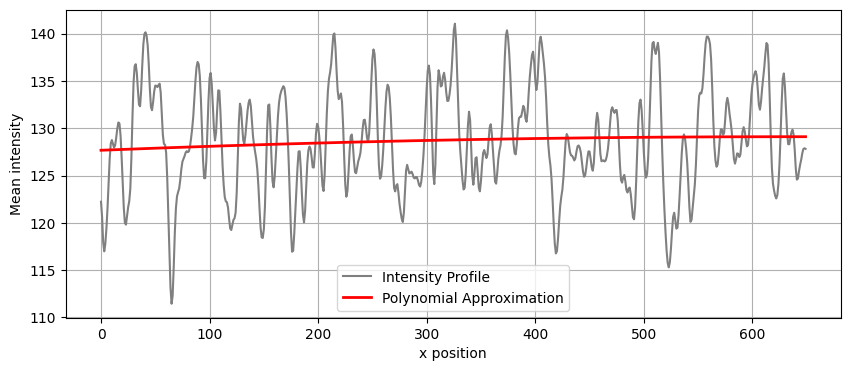

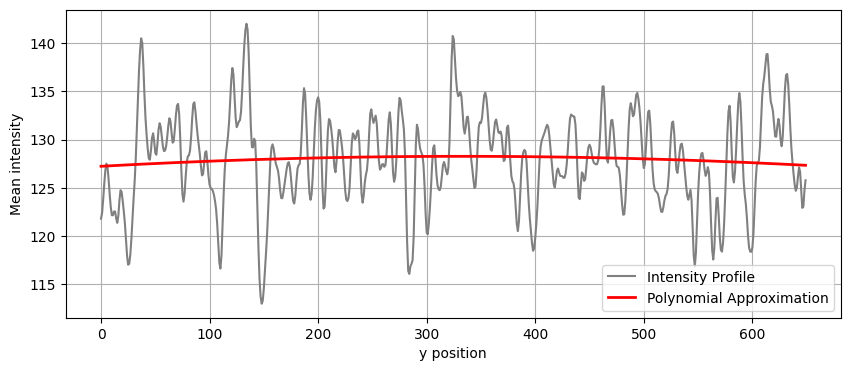

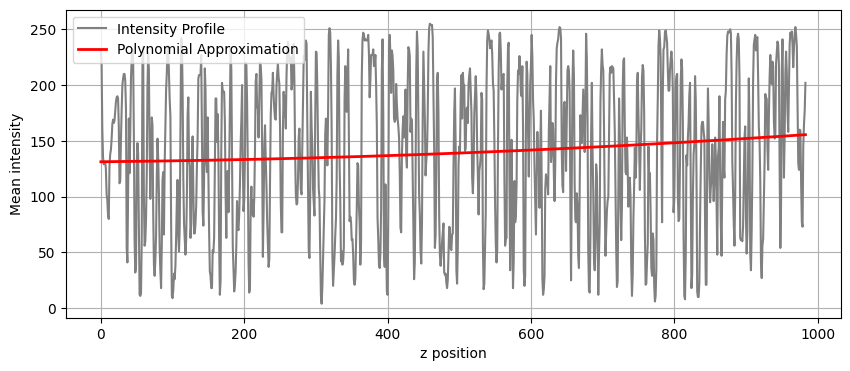

In [10]:
profiles_mean_gray_intensity(processed_model_3d, axis='x')
profiles_mean_gray_intensity(processed_model_3d, axis='y')
profiles_mean_gray_intensity(processed_model_3d, axis='z')

# Binarization

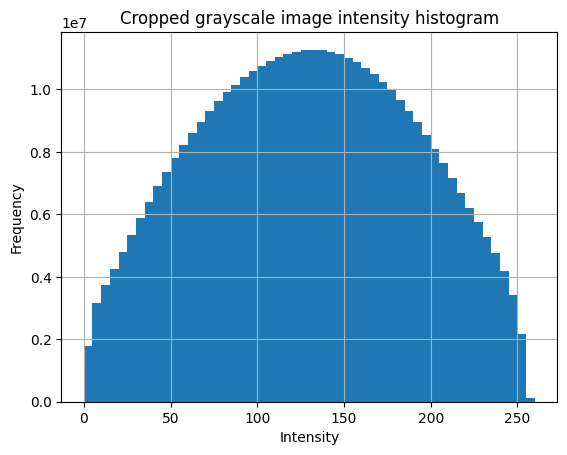

In [11]:
### гистограмма для выбора трешхолдов
def plot_histogram_3d(image_3d, title):
    
    if image_3d.ndim != 3:
        raise ValueError("Input image must be a 3D numpy array.")
    
    pixel_vals = image_3d.ravel()
    step = 5
    bins = np.arange(0, 256 + step, step)  # от 0 до 255 с шагом step
    plt.hist(pixel_vals, bins=bins, range=[0, 256])
    plt.title(title)
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_histogram_3d(processed_model_3d, 'Cropped grayscale image intensity histogram')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skimage/segmentation/random_walker_segmentation.py:532: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  (labels, nlabels, mask, inds_isolated_seeds, isolated_values) = _preprocess(labels)


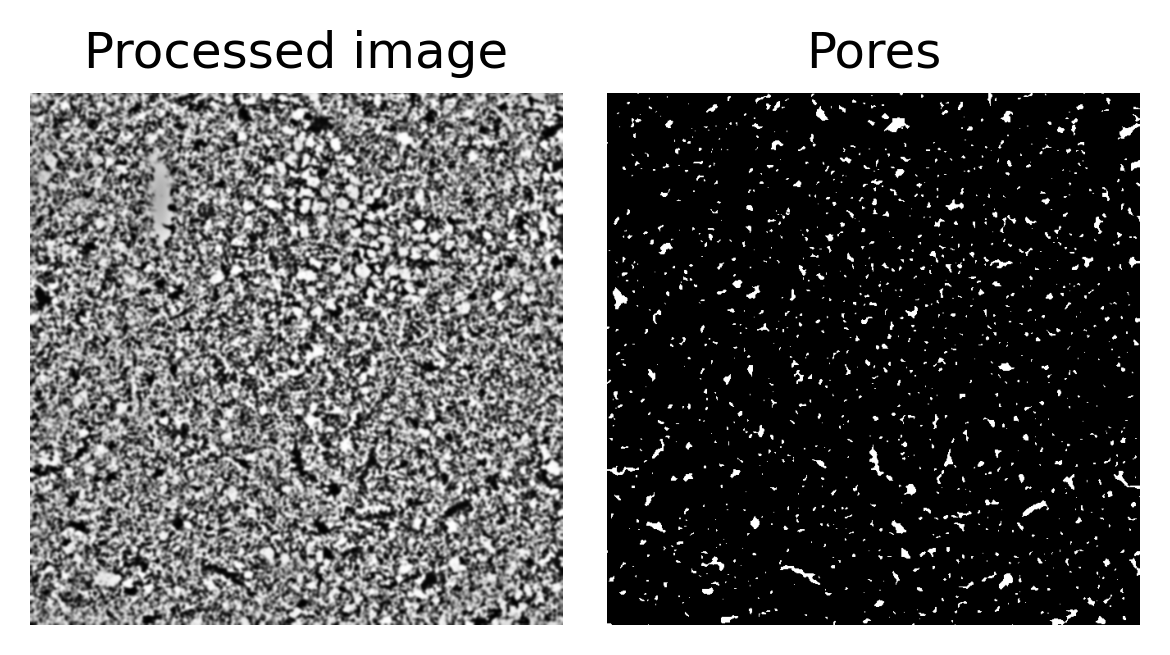

In [12]:
# 1 - белое
image = processed_model_3d[600,:,:].copy() # please add here the copy of your cropped image after task 1

ths_1 = 25
ths_2 = 125


beta = 30
markers = np.zeros(image.shape, dtype=np.uint8)

# 1 - поры, 2 - лед, 3 - матрица
markers[image <= ths_1] = 1
markers[(image > ths_1) & (image < ths_2)] = 2
markers[image >= ths_2] = 3

labels = random_walker(image, markers, beta=beta, mode='bf')

# (pores 1, another - 0)
labels_porous = np.where(labels == 1, 1, 0)

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(4, 3))

ax[0].imshow(processed_model_3d[600, :, :], cmap='gray')
ax[0].set_title('Processed image')
ax[0].axis('off')

ax[1].imshow(labels_porous, cmap='gray')
ax[1].set_title('Pores')  
ax[1].axis('off')

plt.tight_layout()
plt.show()

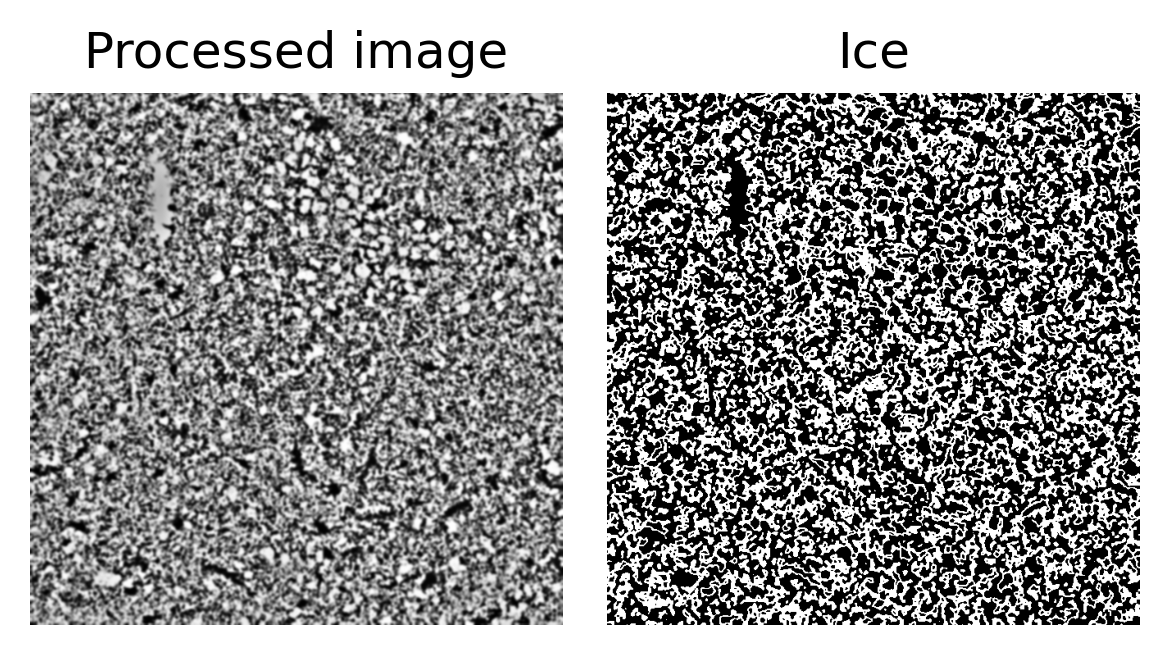

In [13]:
# ice
# (ice 1, another - 0)
labels_ice = np.where(labels == 2, 1, 0)

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(4, 3))

ax[0].imshow(processed_model_3d[600, :, :], cmap='gray')
ax[0].set_title('Processed image')
ax[0].axis('off')

ax[1].imshow(labels_ice, cmap='gray')
ax[1].set_title('Ice')  
ax[1].axis('off')

plt.tight_layout()
plt.show()

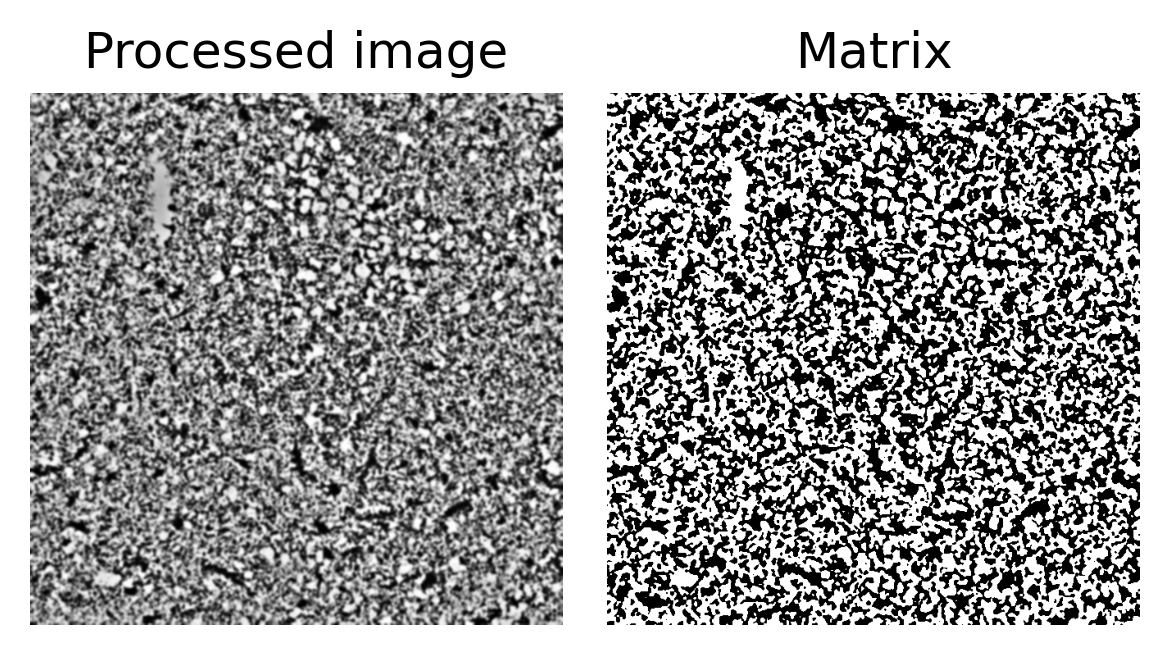

In [14]:
# matrix
# (matrix 1, another - 0)
labels_matrix = np.where(labels == 3, 1, 0)

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(4, 3))

ax[0].imshow(processed_model_3d[600, :, :], cmap='gray')
ax[0].set_title('Processed image')
ax[0].axis('off')

ax[1].imshow(labels_matrix, cmap='gray')
ax[1].set_title('Matrix')  
ax[1].axis('off')

plt.tight_layout()
plt.show()

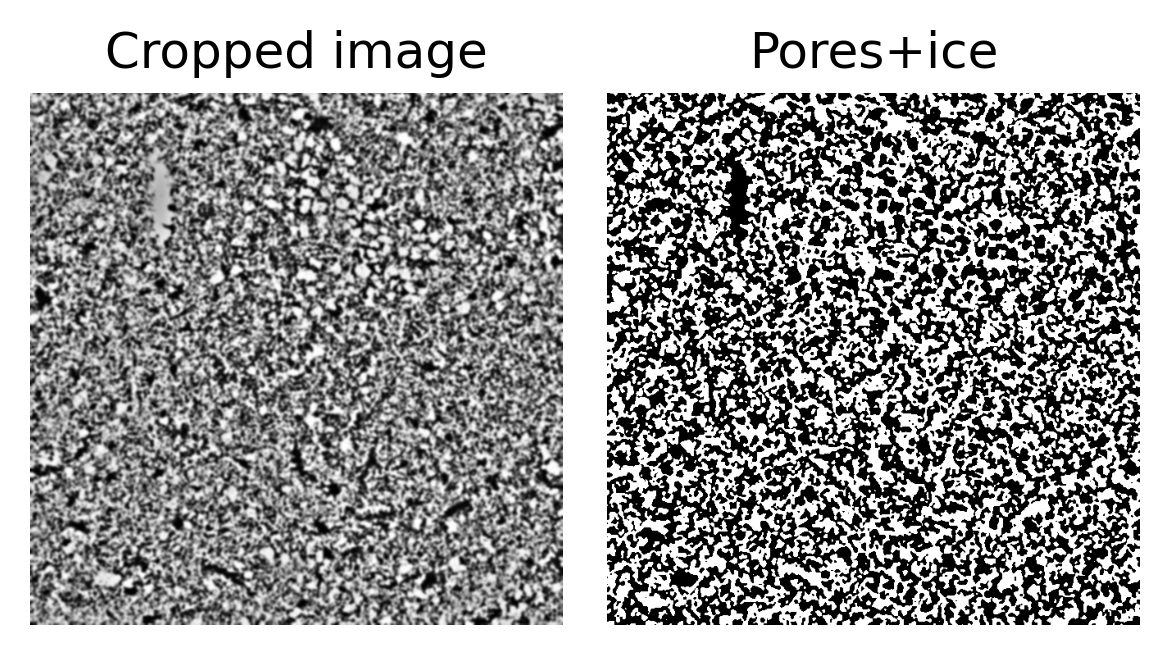

In [15]:
# pores+ice

labels_ice_and_pores = np.where(labels == 3, 0, 1)

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(4, 3))

ax[0].imshow(processed_model_3d[600, :, :], cmap='gray')
ax[0].set_title('Cropped image')
ax[0].axis('off')

ax[1].imshow(labels_ice_and_pores, cmap='gray')
ax[1].set_title('Pores+ice')  
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Apply to 3D model 

In [16]:
image = processed_model_3d.copy() # please add here the copy of your cropped image after task 1
beta = 30
markers = np.zeros(image.shape, dtype=np.uint8)

# 1 - поры, 2 - лед, 3 - матрица
markers[image <= ths_1] = 1
markers[(image > ths_1) & (image < ths_2)] = 2
markers[image >= ths_2] = 3


### end of your code

labels = random_walker(image, markers, beta=beta, mode='bf')

### your code here - display the pores (pores 1, another - 0)
# получились бинаризованные модельки каждой из "фаз"
labels_porous = np.where(labels == 1, 1, 0)
labels_ice = np.where(labels == 2, 1, 0)
labels_matrix = np.where(labels == 3, 1, 0)
labels_ice_and_pores = np.where(labels == 3, 0, 1)

In [17]:
labels_matrix.shape

(984, 650, 650)

In [18]:
labels.shape

(984, 650, 650)

# Calculate the characteristics 

In [19]:
# Porosity
num_ones = np.sum(labels_porous == 1)
total_pixels = labels_porous.size
percentage_of_ones = (num_ones / total_pixels) * 100
print(f'Free porosity: {percentage_of_ones:.2f}%')

Free porosity: 4.52%


In [20]:
# All porocity (with the part filled with ice)
num_ones = np.sum(labels_ice_and_pores == 1)
total_pixels = labels_ice_and_pores.size
percentage_of_ones = (num_ones / total_pixels) * 100
print(f'All porosity: {percentage_of_ones:.2f}%')

All porosity: 47.69%


In [21]:
# Which part of pores filled with ice
num_ice_and_porosity = np.sum(labels_ice_and_pores == 1)
num_ice = np.sum(labels_ice == 1)
total_pixels = labels_porous.size
percentage_of_ones = (num_ice / num_ice_and_porosity) * 100
print(f'Pore filling with ice: {percentage_of_ones:.2f}%')

Pore filling with ice: 90.52%


In [22]:
# Ice content in the sample
num_ice = np.sum(labels_ice == 1)
total_pixels = labels_porous.size
percentage_of_ones = (num_ice / total_pixels) * 100
print(f'Part of ice in the hole sample: {percentage_of_ones:.2f}%')

Part of ice in the hole sample: 43.17%


# Vizualization

In [23]:
# import numpy as np
# from mayavi import mlab

# # Пример массива данных с дискретными значениями 1, 2, 3
# # small_cube = np.random.randint(1, 4, size=(100, 100, 100))  # Пример массива
# small_cube = labels[100:400, 200:500, 200:500]
# # Визуализация поверхностей с разными цветами для значений
# field = mlab.pipeline.scalar_field(small_cube)
# # 1 - поры, 2 - лед, 3 - матрица

# # Для значения 1 (например, красный)
# mlab.pipeline.iso_surface(field, contours=[1], color=(1, 0, 0))

# # Для значения 2 (например, синий)
# mlab.pipeline.iso_surface(field, contours=[2], color=(0, 0, 1))

# # Для значения 3 (например, зеленый)
# mlab.pipeline.iso_surface(field, contours=[3], color=(0, 1, 0))

# # Показать результат
# mlab.show()
